# basic set up

In [1]:
#basic set up
%matplotlib inline
from netflow_main import *
import logzero
from logzero import logger
import yaml

In [2]:
def flush_log_file(log_file):
    with open(log_file, 'w'):
        pass

log_file = 'test.log'
flush_log_file(log_file)

logzero.logfile(log_file)
logger.info(f'{log_file} created.')
logger.info('------------------------------------')

def load_config(config_file, logger=logger):
    print(f"Loading config from {config_file}")
    with open(config_file, 'r') as f:
        config = yaml.safe_load(f)
    # print the config content to the logger file one by one
    for key in config:
        logger.info(f"{key}:")
        logger.info(f"{config[key]}:")
    logger.info('------------------------------------')
    
    return config

# TODO - make params_file an argument to the python script
config = load_config('./params/params_test.yaml' )

indir = config['input_dir']
outdir = config['output_dir']
outdir_fig = config['output_fig_dir']
pointings_file = config['pointings_file']
gurobiOptions = config['gurobiOptions']
tele_params = config['tele_params']
ra_range = config['ra_range']
dec_range = config['dec_range']
bench_config = config['bench_config']
two_stage = config['two_stage']

fov_diag = tele_params['fov']



########################
classdict = def_classdict()

# print the classdict content to the logger file one by one
for key in classdict:
    logger.info(f"{key}:")
    logger.info(f"{classdict[key]}:")
logger.info('------------------------------------')

########################
from utils.io import read_pointings
pointings = read_pointings(pointings_file)
selected_pointings = select_pointings(pointings, ra_range, dec_range)
# TODO: how can SSP set otime in a way as realistic as possible?
# set the observation time UTC in pointings 
selected_pointings['otime'] = "2025-08-20T11:00:00Z"

logger.info(selected_pointings)
logger.info('------------------------------------')

[I 250207 13:27:30 2005108132:9] test.log created.
[I 250207 13:27:30 2005108132:10] ------------------------------------
[I 250207 13:27:30 2005108132:18] input_dir:
[I 250207 13:27:30 2005108132:19] ../data_proc/test/:
[I 250207 13:27:30 2005108132:18] input_files:
[I 250207 13:27:30 2005108132:19] {'cos_file': 'cosmology_region3_3h_targets.ecsv', 'fluxstd_file': 'star_region3_3h_targets.ecsv', 'sky_file': 'sky_region3_3h_targets.ecsv'}:
[I 250207 13:27:30 2005108132:18] prefix_list:
[I 250207 13:27:30 2005108132:19] ['sci', 'cal', 'sky']:
[I 250207 13:27:30 2005108132:18] calibration_list:
[I 250207 13:27:30 2005108132:19] [False, True, True]:
[I 250207 13:27:30 2005108132:18] output_dir:
[I 250207 13:27:30 2005108132:19] ../output/test/:
[I 250207 13:27:30 2005108132:18] output_fig_dir:
[I 250207 13:27:30 2005108132:19] ../output/figures/test/:
[I 250207 13:27:30 2005108132:18] pointings_file:
[I 250207 13:27:30 2005108132:19] ../output/pointings/test/cosmology_region3_3h_pointings

Loading config from ./params/params_test.yaml
Select 29 pointings.


In [3]:
########################
t0 = time.time()
tgt = construct_tgt_list(config)
t1 = time.time()
logger.info(f"Time to construct target list: {t1-t0} seconds.")
logger.info('------------------------------------')

# set the stage of cosmology targets to be 1 (i.e. stage=0 for calibration targets to get a uniform distribution for calibration targets)
# TODO: use CobraGroup to get a uniform distribution for calibration targets
for t in tgt:
    if t.targetclass[:3] == 'sci': t.stage = 1

construct target list:
../data_proc/test/cosmology_region3_3h_targets.ecsv
../data_proc/test/star_region3_3h_targets.ecsv
../data_proc/test/sky_region3_3h_targets.ecsv


[I 250207 13:28:12 660354141:5] Time to construct target list: 42.30215072631836 seconds.
[I 250207 13:28:12 660354141:6] ------------------------------------


In total, there are 1671942 targets.


ra_sci range: -9.99989600127509 to 9.999985255758888
dec_sci range: -1.4999856438351629 to 0.49999986377467714
  Your sample (gray), with the pointings (red):


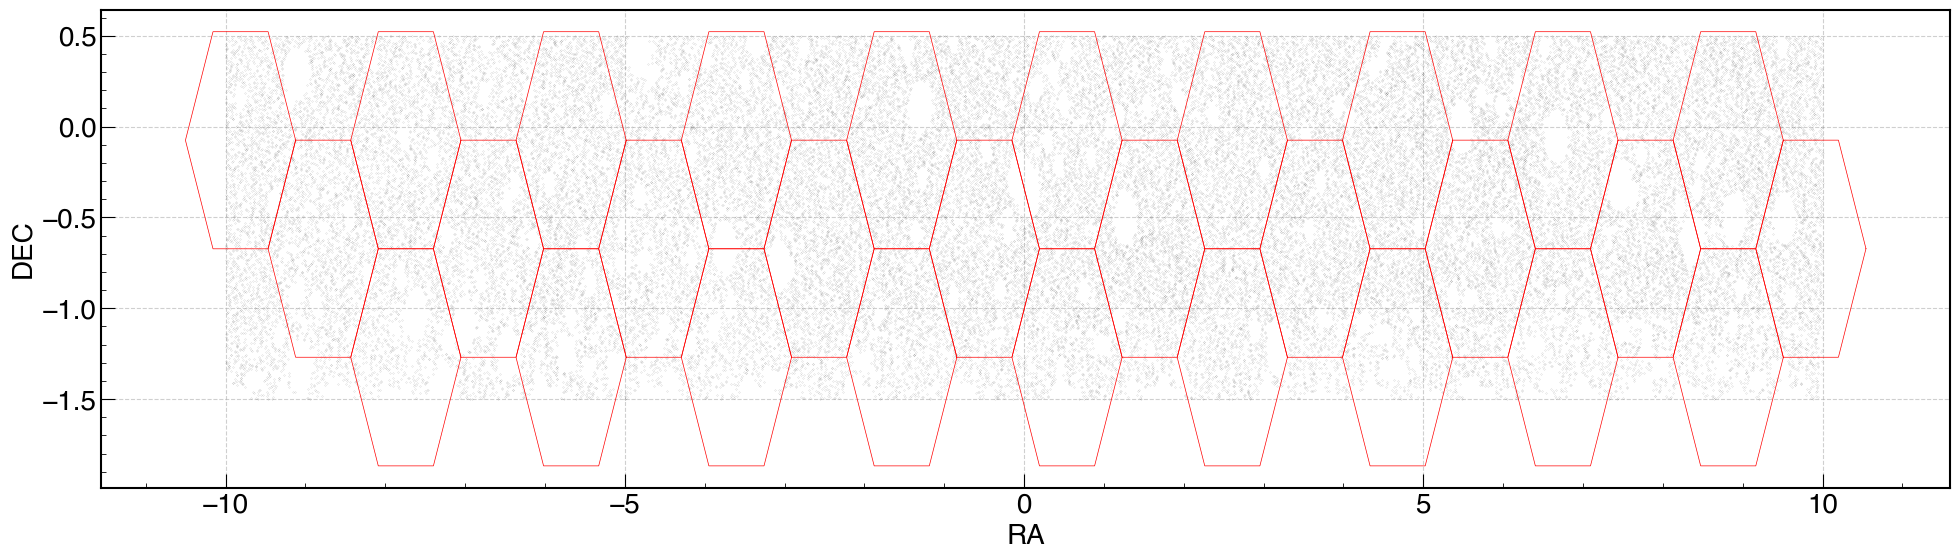

[I 250207 13:28:19 498797999:41] Time to plot selected science targets: 5.822242021560669 seconds.
[I 250207 13:28:19 498797999:42] ------------------------------------


In [4]:
def plot_tgt_sci_select(tgt, pointings, ra_range, dec_range, figname):
    '''
    plot the selected science targets and pointings
    '''
    # sample of sci targets
    sample_sci = []
    for t in tgt:
        if(t.targetclass[:3] == 'sci'): sample_sci.append([t.ID,t.ra,t.dec])  

    sample_sci = np.array(sample_sci)

    ra_sci = sample_sci[:, 1].astype('float')
    dec_sci = sample_sci[:, 2].astype('float')

    # wrap the ra to [-180, 180] for the HSC wide autumn field
    ra_sci[ra_sci>300] -= 360

    print(f"ra_sci range: {ra_sci.min()} to {ra_sci.max()}")
    print(f"dec_sci range: {dec_sci.min()} to {dec_sci.max()}")

    mask_sci = (ra_sci>ra_range[0]) & (ra_sci<ra_range[1]) & (dec_sci>dec_range[0]) & (dec_sci<dec_range[1])

    # plot
    plt.figure(figsize=(20, 6))
    print("  Your sample (gray), with the pointings (red):")
    plt.plot(ra_sci[mask_sci][::10], dec_sci[mask_sci][::10], 'k.', ms=0.2, alpha=0.5)

    for raP, decP in zip(pointings['ppc_ra'], pointings['ppc_dec']):
        flag_fov_reserved = plot_filter_fov(raP, decP, ra_sci[mask_sci], dec_sci[mask_sci], PA=90, n_sci_fov_least=7000, filter_fov=False)

    plt.xlabel('RA', fontsize=20)
    plt.ylabel('DEC', fontsize=20)
    plt.savefig(figname)
    plt.show()
    plt.close()

########################
t0 = time.time()
plot_tgt_sci_select(tgt, selected_pointings, ra_range, dec_range, outdir_fig + './tgt_sci_selected.png')
t1 = time.time()
logger.info(f"Time to plot selected science targets: {t1-t0} seconds.")
logger.info('------------------------------------')


In [5]:
def set_alreadyObserved(config, tgt):
    '''
    Set the alreadyObserved dictionary using the alreadyObserved column in the target list

    Note: tgt.ID and data_table_cos['ID'] are coded same way, e.g. _Cos_ + HSC object_id for cosmology targets
    '''
    fn_cos = config['input_dir'] + config['input_files']['cos_file']
    data_table_cos = ascii.read(fn_cos)

    alreadyObserved={}
    for t in tgt:
        alreadyObserved[t.ID] = 0

    # set the alreadyObserved dictionary using the alreadyObserved column in the target list (needed for the 2nd visit of the field for sure)
    mask_done = data_table_cos['AlreadyObserved'] == 1
    for t in data_table_cos['ID'][mask_done]:
        alreadyObserved[t] = 1

    return alreadyObserved

########################
t0 = time.time()
alreadyObserved = set_alreadyObserved(config, tgt)
t1 = time.time()
logger.info(f"Time to set alreadyObserved: {t1-t0} seconds.")
logger.info('------------------------------------')

[I 250207 13:30:02 810113500:25] Time to set alreadyObserved: 102.8617172241211 seconds.
[I 250207 13:30:02 810113500:26] ------------------------------------


In [6]:
########################
bench, cobracoach = create_bench(layout="calibration", bench_config=bench_config)
collision_sim_version = 2

print("Number of good cobras: %d" % np.sum(bench.cobras.status==1))
print("Number of broken cobras: %d" % np.sum(bench.cobras.status!=1))
logger.info('------------------------------------')

Created cobra coach temp directory: ./cobra_coach_temp/


2025-02-07 13:30:08.481Z cobraCoach       30 cobraCoach.py:164 setting invisible cobras: [173, 648, 799, 853, 949, 1173, 1653, 1724, 2182]
2025-02-07 13:30:08.553Z cobraCoach       30 cobraCoach.py:175 setting bad cobras: [47, 50, 173, 193, 347, 361, 648, 754, 799, 821, 853, 949, 1150, 1173, 1208, 1210, 1520, 1580, 1653, 1724, 1791, 1825, 1836, 1882, 1903, 2053, 2182, 2352, 2380]
2025-02-07 13:30:08.565Z cobraCoach       20 cobraCoach.py:273 cc connecting to fpga....
2025-02-07 13:30:08.569Z butler           30 butler.py:59 newRun: cobra_coach_temp/20250207_005


Cobras with zero centers: 0
Cobras with zero link lengths: 0
Cobras with too long link lengths: 0


[I 250207 13:30:08 3354007454:7] ------------------------------------


Number of cobras: 2394
Number of good cobras: 2365
Number of broken cobras: 29


'2025-08-20T11:00:00Z'

In [31]:
# TODO-5: check collision_distance, and minSkyTargetsPerInstrumentRegion
# TODO-6: write code to get longer exposure in the 2nd visit for some targets
# TODO-7: test which part of the code is the bottleneck
def execute(pointings, tgt, classdict, alreadyObserved, bench, cobracoach, gurobiOptions, two_stage = False, collision_sim_version = 2, tele_params={"t_obs":900., "posang":0.}):
    '''
    fiber assignment for the targets using netflow
    '''
    raTel, decTel = np.atleast_1d(pointings['ppc_ra']), np.atleast_1d(pointings['ppc_dec'])
    otime = np.atleast_1d(pointings['otime'])

    posang = tele_params['posang']
    t_obs = tele_params['t_obs'] # exposure time in seconds
    
    telescopes = []

    # number of distinct observations
    nvisit = len(raTel)

    # generate telescope pointings for every observation
    for ii in range(nvisit):
        telescopes.append(nf.Telescope(raTel[ii], decTel[ii], posang, otime[ii]))

    # get focal plane positions for all targets and all visits
    tpos = [tele.get_fp_positions(tgt) for tele in telescopes]
    
    # optional: slightly increase the cost for later observations,
    # to observe as early as possible
    vis_cost = [0.1*i for i in range(nvisit)]

    # optional: penalize assignments where the cobra has to move far out
    def cobraMoveCost(dist):
        return 0.01*dist 
    
    # necessary: penalize assignments near the black dots
    # note distance is in mm, same as in cobraMoveCost
    # dot_penalty is not use by Kiyoto or Wanqiu
    #def blackDotPenalty(dist):
    #    return max(0, 0.01*(1. - 0.5 * dist)) 
    
    forbiddenPairs = []
    for i in range(nvisit):
        forbiddenPairs.append([])

    print("solving the problem for stage=0 targets.")
    done = False
    while not done:
        # compute observation strategy for stage=0 targets (default: stage=0, preassigned=None)
        prob0 = nf.buildProblem(bench, tgt, tpos, classdict, t_obs,
                               vis_cost, cobraMoveCost=cobraMoveCost,
                               collision_distance=2., elbow_collisions=True,
                               gurobi=True, gurobiOptions=gurobiOptions,
                               alreadyObserved=alreadyObserved,
                               forbiddenPairs=forbiddenPairs, 
                               blackDotPenalty=blackDotPenalty)

        prob0.solve()
        Obj0 = prob0._prob.objVal
        
        # extract solution for stage=0
        res0 = [{} for _ in range(nvisit)]
        for k1, v1 in prob0._vardict.items():
            if k1.startswith("Tv_Cv_"):
                visited = prob0.value(v1) > 0
                if visited:
                    _, _, tidx, cidx, ivis = k1.split("_")
                    res0[int(ivis)][int(tidx)] = int(cidx)
        #    
        print("Checking for trajectory collisions")
        ncoll = 0
        for ivis, (vis, tp) in enumerate(zip(res0, tpos)):
            selectedTargets = np.full(len(bench.cobras.centers), NULL_TARGET_POSITION)
            ids = np.full(len(bench.cobras.centers), NULL_TARGET_ID)
            for tidx, cidx in vis.items():
                selectedTargets[cidx] = tp[tidx]
                ids[cidx] = ""
            for i in range(selectedTargets.size):
                if selectedTargets[i] != NULL_TARGET_POSITION:
                    dist = np.abs(selectedTargets[i]-bench.cobras.centers[i])
                    if dist > bench.cobras.L1[i] + bench.cobras.L2[i]:
                        logger.warning(
                            f"(CobraId={i}) Distance from the center exceeds L1+L2 ({dist} mm)"
                        )

            if collision_sim_version == 2:
                simulator = CollisionSimulator2(bench, cobracoach, TargetGroup(selectedTargets, ids))
            else:
                simulator = CollisionSimulator(bench, TargetGroup(selectedTargets, ids))

            simulator.run()
            if np.any(simulator.endPointCollisions):
                print("ERROR: detected %d end point collision, which should be impossible" % simulator.nEndPointCollisions)

            coll_tidx = []
            for tidx, cidx in vis.items():
                if simulator.collisions[cidx]:
                    coll_tidx.append(tidx)
            ncoll += len(coll_tidx)
            for i1 in range(0,len(coll_tidx)):
                found = False
                for i2 in range(i1 + 1, len(coll_tidx)):
                    if np.abs(tp[coll_tidx[i1]] - tp[coll_tidx[i2]])<10:
                        forbiddenPairs[ivis].append((coll_tidx[i1],coll_tidx[i2]))
                        found = True
                if not found:  # not a collision between two active Cobras
                    forbiddenPairs[ivis].append((coll_tidx[i1],))

        print("trajectory collisions found:", ncoll)
        done = ncoll == 0
        
    print("Done: solving the problem for stage=0 targets.")
    
    if((two_stage==False)):
        return res0, tpos, telescopes
    
    ####################################
    print("solving the problem for stage=1 targets.")
    #reset forbiddenPairs here again
    forbiddenPairs = []
    for i in range(nvisit):
        forbiddenPairs.append([])
    
    # get preassigned_list
    preassigned_list = [{} for _ in range(nvisit)] #list (dict(TargetID: Cobra index))
    for i, vis in enumerate(res0):
        for tidx, cidx in vis.items():
            preassigned_list[i][tgt[tidx].ID] = cidx
          
    done = False
    while not done:
        #note adding stage=1 in nf.buildProblem() does not make too much difference
        prob1 = nf.buildProblem(bench, tgt, tpos, classdict, t_obs,
                                vis_cost, cobraMoveCost=cobraMoveCost,
                                collision_distance=2., elbow_collisions=True,
                                gurobi=True, gurobiOptions=gurobiOptions,
                                alreadyObserved=alreadyObserved,
                                forbiddenPairs=forbiddenPairs,
                                blackDotPenalty=blackDotPenalty,
                                stage=1, preassigned=preassigned_list)
        
        
        prob1.solve()
        Obj1 = prob1._prob.objVal
            
        # extract solution for stage=1
        res = [{} for _ in range(nvisit)]
        for k1, v1 in prob1._vardict.items():
            if k1.startswith("Tv_Cv_"):
                visited = prob1.value(v1) > 0
                if visited:
                    _, _, tidx, cidx, ivis = k1.split("_")
                    res[int(ivis)][int(tidx)] = int(cidx)
        

        print("Checking for trajectory collisions")
        ncoll = 0
        for ivis, (vis, tp) in enumerate(zip(res, tpos)):
            selectedTargets = np.full(len(bench.cobras.centers), NULL_TARGET_POSITION)
            ids = np.full(len(bench.cobras.centers), NULL_TARGET_ID)
            for tidx, cidx in vis.items():
                selectedTargets[cidx] = tp[tidx]
                ids[cidx] = ""
            for i in range(selectedTargets.size):
                if selectedTargets[i] != NULL_TARGET_POSITION:
                    dist = np.abs(selectedTargets[i]-bench.cobras.centers[i])
                    if dist > bench.cobras.L1[i] + bench.cobras.L2[i]:
                        logger.warning(
                            f"(CobraId={i}) Distance from the center exceeds L1+L2 ({dist} mm)"
                        )

            if collision_sim_version == 2:
                simulator = CollisionSimulator2(bench, cobracoach, TargetGroup(selectedTargets, ids))
            else:
                simulator = CollisionSimulator(bench, TargetGroup(selectedTargets, ids))
            simulator.run()
            if np.any(simulator.endPointCollisions):
                print("ERROR: detected %d end point collision, which should be impossible" % simulator.nEndPointCollisions)
            coll_tidx = []
            for tidx, cidx in vis.items():
                if simulator.collisions[cidx]:
                    coll_tidx.append(tidx)
            ncoll += len(coll_tidx)
            for i1 in range(0,len(coll_tidx)):
                found = False
                for i2 in range(i1+1,len(coll_tidx)):
                    if np.abs(tp[coll_tidx[i1]]-tp[coll_tidx[i2]])<10:
                        forbiddenPairs[ivis].append((coll_tidx[i1],coll_tidx[i2]))
                        found = True
                if not found:  # not a collision between two active Cobras
                    forbiddenPairs[ivis].append((coll_tidx[i1],))

        print("trajectory collisions found:", ncoll)
        done = ncoll == 0
        
    print("Done: solving the problem for stage=1 targets.")
    ####################################
    
    clear_output()
    
    if((two_stage == True)):
        print("objVal0 = %f, objVal1=%f" % (Obj0, Obj1))   
    else:
        print("objVal0 = %f" % (Obj0)) 
    
    return res, tpos, telescopes

# run netflow_main

In [34]:
selected_pointings[1:2]

ppc_code,ppc_ra,ppc_dec,ppc_pa,ppc_resolution,ppc_priority,obstime,otime
str9,float64,float64,float64,str1,int32,float64,str20
Autumn_1,-8.776999999999987,-0.672,0.0,L,1,nan,2025-08-20T11:00:00Z


[I 250207 15:00:17 662927046:19] Time to execute netflow for pointing (Autumn_1, -8.776999999999987, -0.672): 552.1849386692047 seconds.


objVal0 = 10.441546, objVal1=4288477.024104
exposure 0:
  assigned Cobras: 2192
   sky: 400
   sci_P1: 1592
   cal: 200
exposure 0:
assigned Cobras(%): 91.56%; gal--66.50%, anc--0.00%, sky--16.71%, star--8.35%
comp_out= {'cal': 0.4366812227074236, 'sci_P1': 0.07221919796770096, 'sky': 0.007036678687659424}
['sci_P1']


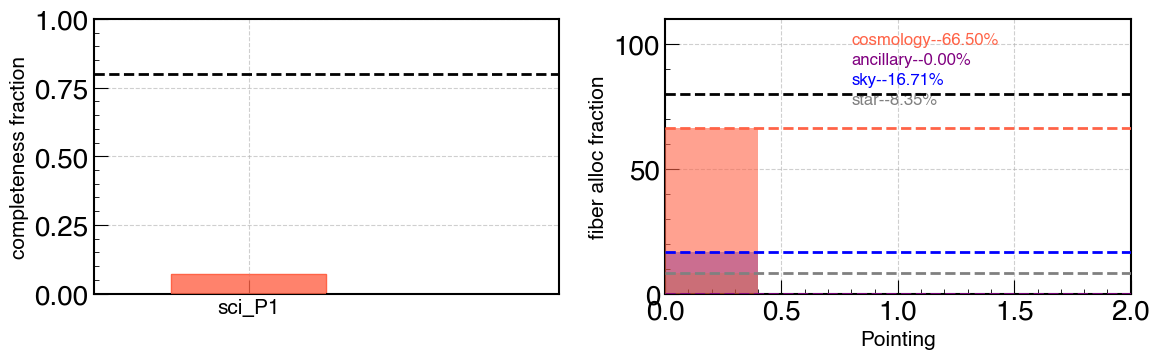

[I 250207 15:00:19 662927046:35] Time to calculate completeness: 1.476245403289795 seconds.
[I 250207 15:00:19 662927046:43] Time to update alreadyObserved: 0.010634899139404297 seconds.


comp_out_tmp1 =  {'cal': 0.4366812227074236, 'sci_P1': 0.07221919796770096, 'sky': 0.007036678687659424}


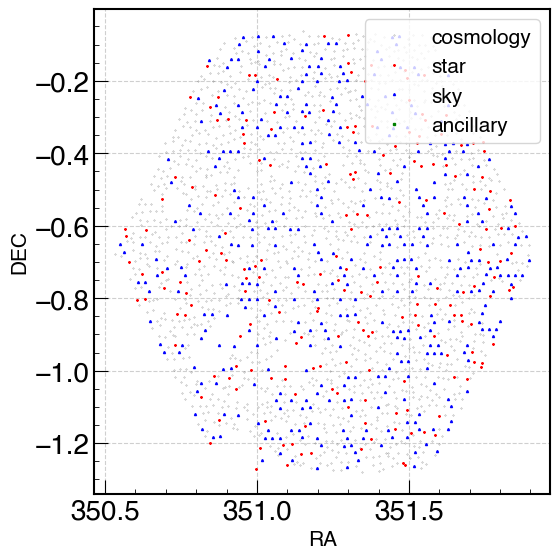

[I 250207 15:00:20 662927046:49] Time to plot tgt_done.png: 0.9498498439788818 seconds.


In [35]:
########################
outfn_list = []
tgt_id_done_list = np.array([])
tgt_ra = np.array([tgt[i].ra for i in range(len(tgt))])
tgt_dec = np.array([tgt[i].dec for i in range(len(tgt))])

# wrap the ra to [-180, 180] for the HSC wide autumn field
tgt_ra[tgt_ra>300] -= 360

for pointing in selected_pointings[1:2]:
    # select targets in the FoV of each pointing
    t0 = time.time()
    mask_tgt = (tgt_ra>pointing['ppc_ra']-fov_diag/2.) & (tgt_ra<pointing['ppc_ra']+fov_diag/2.) & (tgt_dec>pointing['ppc_dec']-fov_diag/2.) & (tgt_dec<pointing['ppc_dec']+fov_diag/2.)
    tgt_peak = np.array(tgt)[mask_tgt].tolist()
    print("pointing - (%f, %f): %d targets selected for the netflow run." % (pointing['ppc_ra'], pointing['ppc_dec'], len(tgt_peak)))

    res, tpos, telescopes = execute(pointing, tgt_peak, classdict, alreadyObserved, bench, cobracoach, gurobiOptions, two_stage=two_stage, tele_params=tele_params)
    t1 = time.time()
    logger.info(f"Time to execute netflow for pointing ({pointing['ppc_code']}, {pointing['ppc_ra']}, {pointing['ppc_dec']}): {t1-t0} seconds.")

    outfn = '%s_nf_output.txt'%(pointing['ppc_code'])
    write_output(tgt_peak, res, tpos, telescopes, outdir, outfn)
    outfn_list.append(outdir + outfn)
        
    # calculate the completeness and fiber assignment fraction
    comp_out_tmp1 = cal_completeness(tgt_peak, res, tpos, telescopes, Plot=True, fn_fig=outdir_fig+'%s_fibeff_comp.jpg'%(pointing['ppc_code']), \
                                    Save=True, fn_fibeff=outdir+'%s_fibeff.txt'%(pointing['ppc_code']))
        
    # output the completeness
    data_dict = {key: [value] for key, value in comp_out_tmp1.items()}
    df = pd.DataFrame(data_dict)
    df.to_csv(outdir + '%s_comp.txt'%(pointing['ppc_code']), index=False)
    print("comp_out_tmp1 = ", comp_out_tmp1)
    t2 = time.time()
    logger.info(f"Time to calculate completeness: {t2-t1} seconds.")

    # update alreadyObserved dict
    # TODO: if this is slow, make it faster
    tgt_id_done = np.loadtxt(outdir + outfn, usecols=(0, ), unpack=True, dtype='str')
    for t in tgt_id_done:
        if(t[1:4]=='Cos'): alreadyObserved[str(t)] = 1 #TODO: check if this is correct
    t3 = time.time()
    logger.info(f"Time to update alreadyObserved: {t3-t2} seconds.")
    

    tgt_id_done_list = np.append(tgt_id_done_list, tgt_id_done)
    plot_tgt_done([outdir+outfn], outdir_fig+'tgt_done_%s.jpg'%(pointing['ppc_code']), figsize=(6, 6))
    t4 = time.time()
    logger.info(f"Time to plot tgt_done.png: {t4-t3} seconds.")

# TO-DO Lists
+ set up the environment on idark
+ fix the problem of gurobi.lic in py_env_co_fa
+ update the target list after each observation
+ longer exposure option for second visit
+ apply bright star mask to sky/stars
+ generate uniform sky/star fiber assignment 
>>> Masato Onodera - I don't think I can put my script to check the uniformity of the distributions of sky and fluxstd objects against the home positions of science fibers. Please see the following gist how it's made. It uses dcor package for the comparsion, so making your own should be simple.
For the GA Fornax design, there is no configuration with p<0.05 (if my calculation is right).
https://gist.github.com/monodera/4c6fef2ce6a8370338250cd78ac78f26

>>> refer GA group code -
https://github.com/Subaru-PFS-GA/ga_targeting/blob/master/nb/examples/netflow/8_cobra_groups.ipynb